### 《28天玩转TensorFlow2》第13天：TensorFlow2项目实战—基于CNN+RNN和TCN的股票预测

## 一、CNN+RNN

基于CNN和RNN的模型就是利用CNN作为提取数据特征，因为RNN的输入数据维度是(样本数,时间步长,特征)，将其维度改为(样本数,1,时间步长,特征)就可以利用用1维的卷积进行计算。本例用到的结构如下：

In [35]:
%%html
<img src='13.01.png', width=800>

## 二、程序实现

## 0 运行环境

In [36]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import sys
import shutil
import time 
import os
print('numpy版本：', np.__version__) # 版本为1.18.5 高了报错
print('python版本：', sys.version)
print('tensorlfow版本：',tf.__version__)
print('可用GPU数量：', len(tf.config.experimental.list_physical_devices('GPU')))
print('GPU显卡信息：')
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

numpy版本： 1.18.5
python版本： 3.8.8 (default, Feb 24 2021, 15:54:32) [MSC v.1928 64 bit (AMD64)]
tensorlfow版本： 2.2.0
可用GPU数量： 1
GPU显卡信息：
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1650 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



## 1 数据说明

2013-2018年全球505家上市公司的每日股票价格数据。数据特征包括日期，开盘价，最高价，最低价，收市价，交易量以及公司股票代码。本文要预测未来的股票的收市价。

In [37]:
# 数据
STOCK_DATA = pd.read_csv('all_stocks_5yr.csv')
STOCK_DATA.head(3)

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL


In [38]:
# 本文研究的公司
COMPANY_STOCK = {'苹果':'AAPL','亚马逊':'AMZN','谷歌':'GOOGL','微软':'MSFT'}

# 根据股票代码获得数据
def get_data(sname, sdata=STOCK_DATA):
    stock_data = sdata[sdata['Name']==sname]
    # 将日期列转化为日期格式
    c_stock_data =stock_data.copy()
    c_stock_data.loc[:, 'date'] = pd.to_datetime(stock_data['date'])
    # 按日期升序排列
    c_stock_data.sort_values('date', ascending=True,inplace=True)
    return c_stock_data

In [39]:
# 数据源
model_data = get_data(COMPANY_STOCK['亚马逊'])
model_data

,date,open,high,low,close,volume,Name
46387,2013-02-08,261.40,265.25,260.555,261.95,3879078,AMZN
46388,2013-02-11,263.20,263.25,256.600,257.21,3403403,AMZN
46389,2013-02-12,259.19,260.16,257.000,258.70,2938660,AMZN
46390,2013-02-13,261.53,269.96,260.300,269.47,5292996,AMZN
46391,2013-02-14,267.37,270.65,265.400,269.24,3462780,AMZN
...,...,...,...,...,...,...,...
47641,2018-02-01,1445.00,1459.88,1385.140,1390.00,9113808,AMZN
47642,2018-02-02,1477.39,1498.00,1414.000,1429.95,11125722,AMZN
47643,2018-02-05,1402.62,1458.98,1320.720,1390.00,11494985,AMZN
47644,2018-02-06,1361.46,1443.99,1351.790,1442.84,11066819,AMZN


## 2 特征工程

In [40]:
# 构建特征工程
def build_feature(exdf):
    c_exdf = exdf.copy()
    # 将日期的年月周几提取出来
    c_exdf.loc[:, '月']  = c_exdf['date'].dt.month
    c_exdf.loc[:, '日'] = c_exdf['date'].dt.day
    c_exdf.loc[:, '星期']  = c_exdf['date'].dt.weekday+1
    
    # 价格特征
    c_exdf['High-Low'] = c_exdf['high'] - c_exdf['low']
    c_exdf['High/Low'] = c_exdf['high'] / c_exdf['low']
    
    c_exdf['Close/Open'] = c_exdf['close'] / c_exdf['open']
    c_exdf['Close-Open'] = c_exdf['close'] - c_exdf['open']
    
    c_exdf['Mean'] = c_exdf[['open', 'high', 'low', 'close']].mean(axis=1)
    c_exdf['High/Mean'] = c_exdf['high'] / c_exdf['Mean']
    c_exdf['Low/Mean'] = c_exdf['low'] / c_exdf['Mean']
    
    c_exdf['Median'] = c_exdf[['open', 'high', 'low', 'close']].median(axis=1)
    c_exdf['High/Median'] = c_exdf['high'] / c_exdf['Median']
    c_exdf['Low/Median'] = c_exdf['low'] / c_exdf['Median']
    
    c_exdf['Mean/Median'] = c_exdf['Mean'] / c_exdf['Median']
    
    return c_exdf

In [41]:
feature_data = build_feature(model_data)
feature_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1259 entries, 46387 to 47645
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         1259 non-null   datetime64[ns]
 1   open         1259 non-null   float64       
 2   high         1259 non-null   float64       
 3   low          1259 non-null   float64       
 4   close        1259 non-null   float64       
 5   volume       1259 non-null   int64         
 6   Name         1259 non-null   object        
 7   月            1259 non-null   int64         
 8   日            1259 non-null   int64         
 9   星期           1259 non-null   int64         
 10  High-Low     1259 non-null   float64       
 11  High/Low     1259 non-null   float64       
 12  Close/Open   1259 non-null   float64       
 13  Close-Open   1259 non-null   float64       
 14  Mean         1259 non-null   float64       
 15  High/Mean    1259 non-null   float64       
 16  L

## 3 构建数据集

In [42]:
# 利用前PAST_DAYS天（包括今天）的数据，预测未来FUTURE_DAYS天（明天开始）的
PAST_DAYS = 7
FUTURE_DAYS = 7

In [43]:
# 特征列
FEATURE = ['open','high','low','High-Low','High/Low',
          'Close/Open','Close-Open','Mean','High/Mean','Low/Mean',
          'Median','High/Median','Low/Median','月','日','星期','Mean/Median','close']
# 目标列
TARGET = ['volume']

#### 所以用于模型训练的输入数据：

 + 目标列的过去PAST_DAYS数据
 
#### 输出数据：
 
 + 特征列的未来FUTURE_DAYS数据
 
针对时间序列数据模型，为了防止数据泄露问题导致的线上效果好，实际部署效果差：
 + 1 数据集需要按照时间序列顺序进行分割；
 + 2 根据训练数据集的值对三个数据集进行最小最大归一化；

In [44]:
# 训练数据占比0.78，验证数据占比0.14，测试数据集占比0.08
def split_data(df, train_p=0.78, val_p=0.14, feature=FEATURE, target=TARGET, pdays=PAST_DAYS, fdays=FUTURE_DAYS):
    # 数据集
    n = len(df)
    train_df = df[0:int(n*train_p)]  # 训练
    val_df = df[int(n*train_p):int(n*(train_p+val_p))] # 验证
    test_df = df[int(n*(train_p+val_p)):] # 测试

    # 开始进行标准化
    #存入字典
    feature_dict = {}
    for k in feature+target:
        f_data = train_df[k].values # 训练数据集
        min_n, max_n = np.min(f_data), np.max(f_data)
        # 记录
        feature_dict[k] = {'min':min_n, 'max':max_n}
    
    # 开始标准化
    def trans_data(df, exdict=feature_dict):
        c_df = df.copy()
        for k in exdict:
            c_df[k] = (df[k] - exdict[k]['min']) / (exdict[k]['max'] - exdict[k]['min'])
        return c_df
    
    # 标准化
    train_df_n = trans_data(train_df)
    val_df_n = trans_data(val_df)
    test_df_n = trans_data(test_df)
    
    # 开始构建输入和输出
    def split_in_out(exdf, f=feature, t=target, pds=pdays, fds=fdays):
        in_data = [] # 输入数据
        out_data = [] # 输出数据
        l = len(exdf)  # 所有数据的长度
        need_data_f = exdf[f].values  # 特征数据.特征不包括目标列
        need_data_t = exdf[t].values  # 全部输出数据
        
        # 构建输入
        for s in range(l-fds-pds+1):
            # 特征数据
            indata = need_data_f[s:(s+pds)]
            in_data.append(indata)
            
        # 构建输出
        for s in range(pds,l-fds+1):
            # 特征数据
            outdata = need_data_t[s:(s+fds)]
            out_data.append(outdata)
            
        return np.array(in_data), np.array(out_data)

    # 将数据分割为输入和输出
    x_train, y_train =  split_in_out(train_df_n)   
    x_val, y_val = split_in_out(val_df_n) 
    x_test, y_test = split_in_out(test_df_n) 
    
    return x_train, y_train,x_val, y_val,x_test, y_test,feature_dict

In [45]:
# 数据集的输入输出以及字典:TCN模型的输入
X_train, Y_train, X_val, Y_val, X_test, Y_test, Feature_dict = split_data(feature_data)

In [46]:
print(X_train.shape, X_val.shape, X_test.shape)

(969, 7, 18) (163, 7, 18) (88, 7, 18)


In [47]:
# CNN-RNN模型的输入
X_train_cnn = np.expand_dims(X_train, 1) 
X_val_cnn = np.expand_dims(X_val, 1)
X_test_cnn =np.expand_dims(X_test, 1)

In [48]:
print(X_train_cnn.shape, X_val_cnn.shape, X_test_cnn.shape)

(969, 1, 7, 18) (163, 1, 7, 18) (88, 1, 7, 18)


转换成tf数据管道的形式

In [49]:
# 训练数据集
Train_data = tf.data.Dataset.from_tensor_slices((X_train_cnn, Y_train))
# 验证数据集
Valid_data = tf.data.Dataset.from_tensor_slices((X_val_cnn, Y_val))

# 批处理
Train_data_sb = Train_data.shuffle(4000).batch(64).repeat() #shuffle数越大数据越混乱
Valid_data_b = Valid_data.batch(64).repeat()

## 4 构建模型

In [50]:
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed,GRU
from tensorflow.keras.layers import MaxPooling1D, Flatten,Reshape,Input 

In_shape = X_train_cnn.shape
Out_shape = Y_train.shape

print(In_shape, Out_shape)

# 模型架构 注意：最后一个LSTM\GRU层，return_sequences需要设置为False，之前的需要设置为True
def tf2_model(inshp, outshp, func,name='afy'):
    # 建立模型
    model = tf.keras.Sequential(name=name)
    a,b,c = inshp
    model.add(Input(shape=(a,b,c),name='incnn'))
    
    model.add(TimeDistributed(Conv1D(256, kernel_size=1, activation='relu',data_format = 'channels_first')))
    model.add(TimeDistributed(MaxPooling1D(1)))
    
    model.add(TimeDistributed(Conv1D(128, kernel_size=1, activation='relu',data_format = 'channels_first')))
    model.add(TimeDistributed(MaxPooling1D(1)))
    
    model.add(TimeDistributed(Conv1D(64, kernel_size=1, activation='relu',data_format = 'channels_first')))
    model.add(TimeDistributed(MaxPooling1D(1)))
    
#     model.add(TimeDistributed(Conv1D(128, kernel_size=1, activation='relu',data_format = 'channels_first')))
#     model.add(TimeDistributed(MaxPooling1D(1)))
    model.add(TimeDistributed(Flatten()))

    # LSTM layers
    # Dropouts is one of the hyperparameters#Bidirectional
    model.add(Bidirectional(func(356, return_sequences=False)))
#     model.add(Dropout(0.3))
    # 全连接层
    model.add(Dense(outshp[0]*outshp[1], name='dense1', kernel_initializer=tf.initializers.zeros()))
    # 转换维度层
    model.add(Reshape(outshp, name='reshape'))

    # Adam optimizer is one of the 
    model.compile(optimizer='Adam', loss='mse', metrics=['mae'])
    # 模型信息
    model.summary()
    return model

(969, 1, 7, 18) (969, 7, 1)


In [51]:
# 训练模型的参数
def train_model_lstm_gru(modelpath, model, traindatasb, valdatasb, ltn, lvn, bs=64, e=60):
    # 建立存储模型参数的文件夹
    log_dir = '%s/%s' % (modelpath, int(time.time()))

    #  建立文件夹
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    else:
        shutil.rmtree(log_dir)
        os.mkdir(log_dir)
 
    # 检查点文件中包含验证数据集误差和epoch，此时新保存的模型不会覆盖以前的
    # 下面设置就会覆盖，
    checkpoint_path = "%s/best_model.ckpt" % log_dir

    # 创建一个回调，保证验证数据集误差最小，每一个epoch，只要验证数据集的误差变小，就会保存
    # 只保存权重，不保存模型结构，这样，在调用模型的时候，需要重新加载模型结构
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_weights_only=True, monitor='val_loss',
                                                     mode='min', verbose=1, save_best_only=True)
    # 记录训练过程
    model_history = model.fit(traindatasb,epochs=e, steps_per_epoch=int(ltn/bs),
                              validation_data=valdatasb,
                              validation_steps=int(lvn/bs), callbacks=[cp_callback])
   
    return model_history,checkpoint_path

## 5 模型训练保存

In [52]:
# 模型的输入、输出维度
inshp = tuple(In_shape[-3:])
outshp = tuple(Out_shape[-2:])

# 保存最佳模型的路径
BEST_MODEL_DICT = {}

print(inshp, outshp)

(1, 7, 18) (7, 1)


### 5.1 LSTM

In [53]:
# 存储LSYM模型的路径
SAVE_MODEL_PATH_LSTM =  r'D:\GWTWORK\Tensorflow_time28\LSTM_MODEL'
# 构建LSTM模型
lstm_model = tf2_model(inshp, outshp,  LSTM, name='lstm-af')
#  建立存储模型的文件夹
if not os.path.exists(SAVE_MODEL_PATH_LSTM):
    os.makedirs(SAVE_MODEL_PATH_LSTM)
else:
    shutil.rmtree(SAVE_MODEL_PATH_LSTM)
    os.mkdir(SAVE_MODEL_PATH_LSTM)
# 训练
train_his, train_model_path = train_model_lstm_gru(SAVE_MODEL_PATH_LSTM, lstm_model, Train_data_sb, Valid_data_b, len(X_train), len(X_val))
# 保存最佳模型
BEST_MODEL_DICT['LSTM'] = train_model_path

Model: "lstm-af"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_42 (TimeDis (None, 1, 256, 18)        2048      
_________________________________________________________________
time_distributed_43 (TimeDis (None, 1, 256, 18)        0         
_________________________________________________________________
time_distributed_44 (TimeDis (None, 1, 128, 18)        32896     
_________________________________________________________________
time_distributed_45 (TimeDis (None, 1, 128, 18)        0         
_________________________________________________________________
time_distributed_46 (TimeDis (None, 1, 64, 18)         8256      
_________________________________________________________________
time_distributed_47 (TimeDis (None, 1, 64, 18)         0         
_________________________________________________________________
time_distributed_48 (TimeDis (None, 1, 1152)           0   

Epoch 25/60
15/15 [==============================] - ETA: 0s - loss: 0.0080 - mae: 0.0548
Epoch 00025: val_loss did not improve from 0.00466
15/15 [==============================] - 1s 81ms/step - loss: 0.0080 - mae: 0.0548 - val_loss: 0.0053 - val_mae: 0.0502
Epoch 26/60
15/15 [==============================] - ETA: 0s - loss: 0.0074 - mae: 0.0538
Epoch 00026: val_loss did not improve from 0.00466
15/15 [==============================] - 1s 81ms/step - loss: 0.0074 - mae: 0.0538 - val_loss: 0.0060 - val_mae: 0.0610
Epoch 27/60
15/15 [==============================] - ETA: 0s - loss: 0.0070 - mae: 0.0531
Epoch 00027: val_loss did not improve from 0.00466
15/15 [==============================] - 1s 81ms/step - loss: 0.0070 - mae: 0.0531 - val_loss: 0.0053 - val_mae: 0.0513
Epoch 28/60
15/15 [==============================] - ETA: 0s - loss: 0.0077 - mae: 0.0543
Epoch 00028: val_loss did not improve from 0.00466
15/15 [==============================] - 1s 81ms/step - loss: 0.0077 - mae: 

Epoch 57/60
15/15 [==============================] - ETA: 0s - loss: 0.0044 - mae: 0.0444
Epoch 00057: val_loss did not improve from 0.00466
15/15 [==============================] - 1s 81ms/step - loss: 0.0044 - mae: 0.0444 - val_loss: 0.0053 - val_mae: 0.0496
Epoch 58/60
15/15 [==============================] - ETA: 0s - loss: 0.0049 - mae: 0.0450
Epoch 00058: val_loss did not improve from 0.00466
15/15 [==============================] - 1s 81ms/step - loss: 0.0049 - mae: 0.0450 - val_loss: 0.0059 - val_mae: 0.0554
Epoch 59/60
15/15 [==============================] - ETA: 0s - loss: 0.0045 - mae: 0.0450
Epoch 00059: val_loss did not improve from 0.00466
15/15 [==============================] - 1s 80ms/step - loss: 0.0045 - mae: 0.0450 - val_loss: 0.0056 - val_mae: 0.0521
Epoch 60/60
15/15 [==============================] - ETA: 0s - loss: 0.0047 - mae: 0.0442
Epoch 00060: val_loss did not improve from 0.00466
15/15 [==============================] - 1s 81ms/step - loss: 0.0047 - mae: 

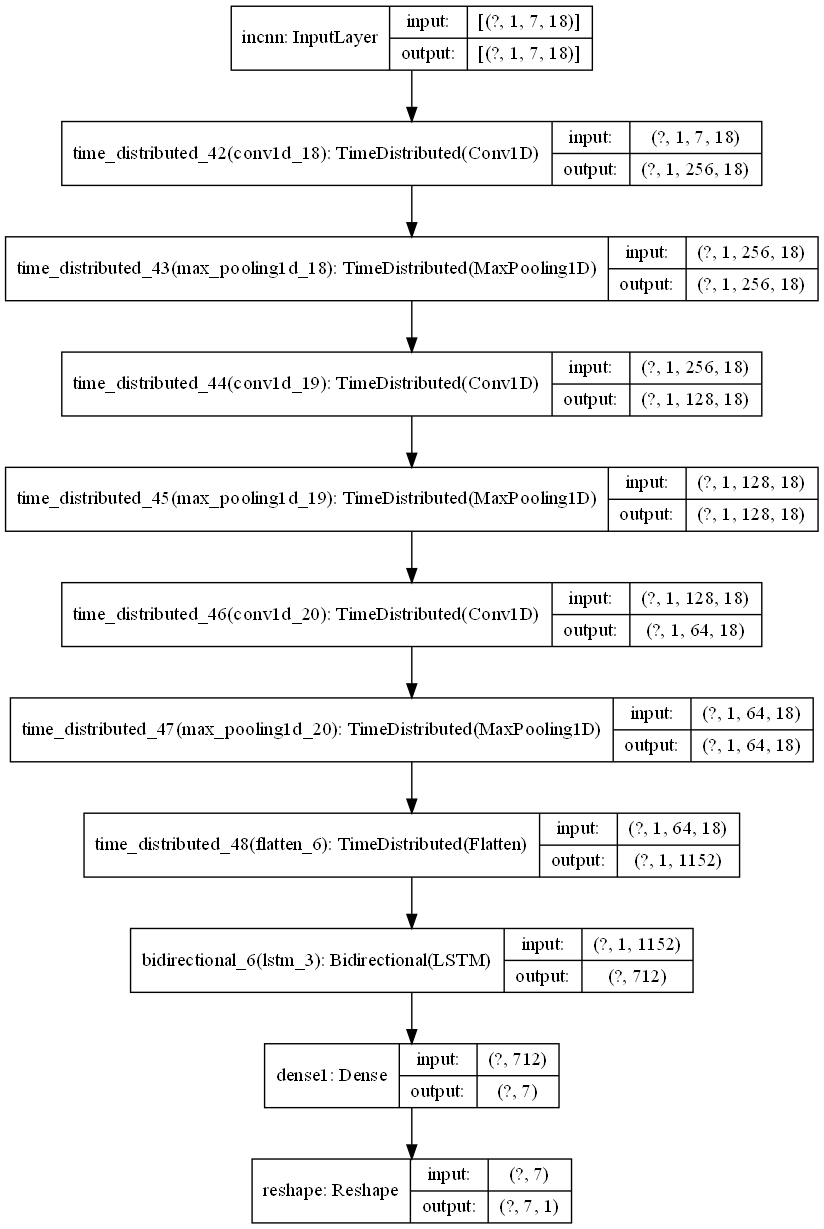

In [54]:
tf.keras.utils.plot_model(lstm_model, to_file='13.01.png', show_shapes=True, 
                          show_layer_names=True,rankdir='TB', dpi=100, expand_nested=True)

### 5.2 GRU

In [55]:
##################GRU模型##################################
# 存储LSYM模型的路径
SAVE_MODEL_PATH_GRU =  r'D:\GWTWORK\Tensorflow_time28\GRU_MODEL'
# 构建GRU模型
kp_model = tf2_model(inshp, outshp, GRU, name='gru-af')
#  建立存储模型的文件夹
 
if not os.path.exists(SAVE_MODEL_PATH_GRU):
    os.makedirs(SAVE_MODEL_PATH_GRU)
else:
    shutil.rmtree(SAVE_MODEL_PATH_GRU)
    os.mkdir(SAVE_MODEL_PATH_GRU)
# 训练
train_his, train_model_path = train_model_lstm_gru(SAVE_MODEL_PATH_GRU, kp_model, Train_data_sb, Valid_data_b, len(X_train), len(X_val))
BEST_MODEL_DICT['GRU'] = train_model_path

Model: "gru-af"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_49 (TimeDis (None, 1, 256, 18)        2048      
_________________________________________________________________
time_distributed_50 (TimeDis (None, 1, 256, 18)        0         
_________________________________________________________________
time_distributed_51 (TimeDis (None, 1, 128, 18)        32896     
_________________________________________________________________
time_distributed_52 (TimeDis (None, 1, 128, 18)        0         
_________________________________________________________________
time_distributed_53 (TimeDis (None, 1, 64, 18)         8256      
_________________________________________________________________
time_distributed_54 (TimeDis (None, 1, 64, 18)         0         
_________________________________________________________________
time_distributed_55 (TimeDis (None, 1, 1152)           0    

Epoch 23/60
15/15 [==============================] - ETA: 0s - loss: 0.0073 - mae: 0.0547
Epoch 00023: val_loss did not improve from 0.00478
15/15 [==============================] - 1s 63ms/step - loss: 0.0073 - mae: 0.0547 - val_loss: 0.0053 - val_mae: 0.0520
Epoch 24/60
15/15 [==============================] - ETA: 0s - loss: 0.0074 - mae: 0.0535
Epoch 00024: val_loss did not improve from 0.00478
15/15 [==============================] - 1s 64ms/step - loss: 0.0074 - mae: 0.0535 - val_loss: 0.0058 - val_mae: 0.0536
Epoch 25/60
15/15 [==============================] - ETA: 0s - loss: 0.0078 - mae: 0.0542
Epoch 00025: val_loss did not improve from 0.00478
15/15 [==============================] - 1s 63ms/step - loss: 0.0078 - mae: 0.0542 - val_loss: 0.0052 - val_mae: 0.0537
Epoch 26/60
15/15 [==============================] - ETA: 0s - loss: 0.0069 - mae: 0.0538
Epoch 00026: val_loss did not improve from 0.00478
15/15 [==============================] - 1s 63ms/step - loss: 0.0069 - mae: 

Epoch 53/60
15/15 [==============================] - ETA: 0s - loss: 0.0060 - mae: 0.0504
Epoch 00053: val_loss did not improve from 0.00478
15/15 [==============================] - 1s 63ms/step - loss: 0.0060 - mae: 0.0504 - val_loss: 0.0069 - val_mae: 0.0602
Epoch 54/60
15/15 [==============================] - ETA: 0s - loss: 0.0061 - mae: 0.0506- ETA: 0s - loss: 0.0055 -
Epoch 00054: val_loss did not improve from 0.00478
15/15 [==============================] - 1s 63ms/step - loss: 0.0061 - mae: 0.0506 - val_loss: 0.0080 - val_mae: 0.0687
Epoch 55/60
15/15 [==============================] - ETA: 0s - loss: 0.0057 - mae: 0.0509
Epoch 00055: val_loss did not improve from 0.00478
15/15 [==============================] - 1s 63ms/step - loss: 0.0057 - mae: 0.0509 - val_loss: 0.0066 - val_mae: 0.0569
Epoch 56/60
15/15 [==============================] - ETA: 0s - loss: 0.0054 - mae: 0.0482- ETA: 0s - loss: 0.0053 -
Epoch 00056: val_loss did not improve from 0.00478
15/15 [=================

### 5.3、TCN

激活虚拟环境，安装包"pip install keras-tcn --no-dependencies"，说明文档参见:https://pypi.org/project/keras-tcn/#keras-tcn 模型输入数据的维度为(样本数，时间步长，特征数)。

In [56]:
from tcn import TCN 
from tensorflow.keras import Input, Model,Sequential

In [76]:
# 模型架构  
def tcn_model_tf(inshp, outshp,name='afrr'):
    # 建立模型
    b,c = inshp
    # 输入层
    # TCN层
    tcn_i = TCN(input_shape=(b, c),nb_filters=128,
                kernel_size=1,
                nb_stacks=3,
                dilations=(1, 2, 6, 8, 10, 12),
                padding='causal',
                use_skip_connections=True,
                dropout_rate=0.0,
                return_sequences=False,
                activation='relu',
                kernel_initializer='he_normal',
                use_batch_norm=False,
                use_layer_norm=True,
                use_weight_norm=False)
    # 全连接层
    dense_i = Dense(outshp[0]*outshp[1], name='dense1', kernel_initializer=tf.initializers.zeros())
    # 转换维度层
    shape_i = Reshape(outshp, name='reshape') 
    # 模型
    model = Sequential([tcn_i,dense_i,shape_i])
    # 优化求解器
    model.compile(optimizer='Adam', loss='mse', metrics=['mae'])
    # 模型信息
    model.summary()
    return model

In [77]:
# 数据维度
tcn_inshp = X_train.shape[-2:]
tcn_outshp = Y_train.shape[-2:]
print(tcn_inshp, tcn_outshp)

(7, 18) (7, 1)


In [78]:
# 存储模型的路径
SAVE_MODEL_PATH_TCN =  r'D:\GWTWORK\Tensorflow_time28\TCN_MODEL'
tcn_model = tcn_model_tf(tcn_inshp, tcn_outshp)
if not os.path.exists(SAVE_MODEL_PATH_TCN):
    os.makedirs(SAVE_MODEL_PATH_TCN)
else:
    shutil.rmtree(SAVE_MODEL_PATH_TCN)
    os.mkdir(SAVE_MODEL_PATH_TCN)

tcn_full_summary(tcn_model, expand_residual_blocks=False)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn_12 (TCN)                 (None, 128)               592000    
_________________________________________________________________
dense1 (Dense)               (None, 7)                 903       
_________________________________________________________________
reshape (Reshape)            (None, 7, 1)              0         
Total params: 592,903
Trainable params: 592,903
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
residual_block_0 (ResidualBl [(None, 7, 128), (None, 7 21888     
_________________________________________________________________
residual_block_1 (ResidualBl [(None, 7, 128), (None, 7 33536     
________________________

In [79]:
# 训练数据集
Train_data = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
# 验证数据集
Valid_data = tf.data.Dataset.from_tensor_slices((X_val, Y_val))

# 批处理
Train_data_sb = Train_data.shuffle(4000).batch(64).repeat() #shuffle数越大数据越混乱
Valid_data_b = Valid_data.batch(64).repeat()

In [80]:
train_his, train_model_path = train_model_lstm_gru(SAVE_MODEL_PATH_TCN, tcn_model, 
                                                   Train_data_sb, Valid_data_b, len(X_train), len(X_val), bs=64, e=60)

BEST_MODEL_DICT['TCN'] = train_model_path

Epoch 1/60
13/15 [=========================>....] - ETA: 0s - loss: 0.1501 - mae: 0.3242
Epoch 00001: val_loss improved from inf to 0.05028, saving model to D:\GWTWORK\Tensorflow_time28\TCN_MODEL/1642662650/best_model.ckpt
15/15 [==============================] - 2s 152ms/step - loss: 0.1322 - mae: 0.2934 - val_loss: 0.0503 - val_mae: 0.2134
Epoch 2/60
14/15 [===========================>..] - ETA: 0s - loss: 0.0277 - mae: 0.1317
Epoch 00002: val_loss improved from 0.05028 to 0.00904, saving model to D:\GWTWORK\Tensorflow_time28\TCN_MODEL/1642662650/best_model.ckpt
15/15 [==============================] - 0s 28ms/step - loss: 0.0274 - mae: 0.1300 - val_loss: 0.0090 - val_mae: 0.0662
Epoch 3/60
13/15 [=========================>....] - ETA: 0s - loss: 0.0124 - mae: 0.0775
Epoch 00003: val_loss improved from 0.00904 to 0.00509, saving model to D:\GWTWORK\Tensorflow_time28\TCN_MODEL/1642662650/best_model.ckpt
15/15 [==============================] - 0s 30ms/step - loss: 0.0124 - mae: 0.0753

Epoch 31/60
14/15 [===========================>..] - ETA: 0s - loss: 0.0082 - mae: 0.0575
Epoch 00031: val_loss did not improve from 0.00458
15/15 [==============================] - 0s 17ms/step - loss: 0.0082 - mae: 0.0577 - val_loss: 0.0081 - val_mae: 0.0691
Epoch 32/60
13/15 [=========================>....] - ETA: 0s - loss: 0.0086 - mae: 0.0599
Epoch 00032: val_loss did not improve from 0.00458
15/15 [==============================] - 0s 18ms/step - loss: 0.0086 - mae: 0.0598 - val_loss: 0.0061 - val_mae: 0.0522
Epoch 33/60
15/15 [==============================] - ETA: 0s - loss: 0.0081 - mae: 0.0572
Epoch 00033: val_loss did not improve from 0.00458
15/15 [==============================] - 0s 17ms/step - loss: 0.0081 - mae: 0.0572 - val_loss: 0.0081 - val_mae: 0.0697
Epoch 34/60
15/15 [==============================] - ETA: 0s - loss: 0.0074 - mae: 0.0544
Epoch 00034: val_loss did not improve from 0.00458
15/15 [==============================] - 0s 18ms/step - loss: 0.0074 - mae: 

## 6 模型效果评估

3个模型3个数据集的预测变量的MAPE，皮尔逊系数以及对比曲线。每一天的预测值为一条曲线。

In [81]:
from scipy.stats import pearsonr as pr
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False 

In [82]:
# 模型预测
def model_predict(xdata, ydata, modeldict, modelstr):
    # 最好的模型
    model_path = modeldict[modelstr]
    print(model_path,modelstr)
    # 模型结构
 
    if modelstr in ['GRU','LSTM']:
        model_s = tf2_model(xdata.shape[-3:], ydata.shape[-2:], eval('tf.keras.layers.%s' % modelstr))
    else:
        model_s = tcn_model_tf(xdata.shape[-2:], ydata.shape[-2:], 'tcn_af')
    
    # 导入最佳参数
    best_p = tf.train.latest_checkpoint(os.path.abspath(os.path.dirname(model_path)))
    model_s.load_weights(best_p).expect_partial()
    # 开始预测
    model_output = model_s.predict(xdata)

    # 按照天数组合数据:预测第一天，预测第二天，等等
    idays_dict = {}
    for idays in range(len(model_output[0])):
        idays_dict[idays] = []
        for kda in model_output:
            idays_dict[idays].append(kda[idays])
    return idays_dict

# 将预测数据还原成原始尺度,特征名为字典：数据为df格式
def back_data(exdict, ydata, fdict=Feature_dict,t=TARGET):
    data_df_dict = {}
    for kin, kva in enumerate(t):
        min_n, max_n = fdict[kva]['min'],fdict[kva]['max']
        f_df = pd.DataFrame()
        # 获取对应的列的数据;取每个样本的第一个值
        oridata = []
        for k in ydata[:-1]:
            oridata.append(k[0][kin])
        for kj in ydata[-1]:
            oridata.append(kj[kin])
        # 还原
        ori_real_data = [i * (max_n-min_n)+ min_n for i in oridata]
        f_df['原始%s' % kva] = ori_real_data
        
        # 在存储预测第几天的预测值
        for kp in exdict:
            # 预测值
            pre_data = [] + [np.nan] * kp
            for kpin in exdict[kp]:
                pre_data.append(kpin[kin])
            pre_data += [np.nan] * (len(exdict)-kp-1)
            f_df['预测%s天' % (kp+1)] = [i * (max_n-min_n)+ min_n for i in pre_data]
        data_df_dict[kva] = f_df
    return data_df_dict

# 计算MAPE,皮尔逊系数
def get_judge(ydata, ydata1):
    # 获取公共部分
    new_y = []
    new_y1 = []
    for kin, kva in enumerate(list(ydata)):
        if not np.isnan(ydata1[kin]):
            new_y.append(kva)
            new_y1.append(ydata1[kin])
            
    def mape(y_true,y_pred):
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        return np.mean(np.abs((y_pred - y_true) / y_true)) * 100
    
    mape_n = mape(new_y, new_y1)
    p_n = pr(new_y, new_y1)
    return ['%.2f%%' % mape_n, '%.2f' % p_n[0]]
    
# 绘图函数
def plot_figure(xdata, xdatatcn, ydata, modeldict=BEST_MODEL_DICT, title_name='训练', t=TARGET):
    model_list = ['LSTM','GRU','TCN']
    # 模型对比图
    fig, axs = plt.subplots(len(model_list), len(t), figsize=(18,13)) 
    for kin, kva in enumerate(model_list):
        # 获取预测数据
        if kva == 'TCN':
            print(xdatatcn.shape)
            idays_dict = model_predict(xdatatcn, ydata, modeldict,kva)
        else:
            idays_dict = model_predict(xdata, ydata, modeldict, kva)
        # 获得还原数据
        data_df_dict = back_data(idays_dict, ydata)
        # 开始绘制
        for dkin, dkva in enumerate(t):
            # 绘图：上边是LSTM,中间是GRU,下边是TCN的模型结果
            df_dk = data_df_dict[dkva] 
            for jk in df_dk:
                if '原始' not in jk:
                    mae_n, p_n = get_judge(df_dk['原始%s'%dkva].values,df_dk[jk].values)
                    axs[kin].plot(df_dk[jk],label=jk+'mae:{},r:{}'.format(mae_n, p_n))
                else:
                    axs[kin].plot(df_dk[jk],label=jk)
            axs[kin].set_title('CNN+'+kva+'：'+dkva if kva in ['LSTM','GRU'] else kva+'：'+dkva)  
            axs[kin].legend()
    plt.suptitle(title_name, fontsize=15,x=0.5,y=0.92)
    plt.legend()
    plt.show()

D:\GWTWORK\Tensorflow_time28\LSTM_MODEL/1642662263/best_model.ckpt LSTM
Model: "afy"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_140 (TimeDi (None, 1, 256, 18)        2048      
_________________________________________________________________
time_distributed_141 (TimeDi (None, 1, 256, 18)        0         
_________________________________________________________________
time_distributed_142 (TimeDi (None, 1, 128, 18)        32896     
_________________________________________________________________
time_distributed_143 (TimeDi (None, 1, 128, 18)        0         
_________________________________________________________________
time_distributed_144 (TimeDi (None, 1, 64, 18)         8256      
_________________________________________________________________
time_distributed_145 (TimeDi (None, 1, 64, 18)         0         
_________________________________________________________

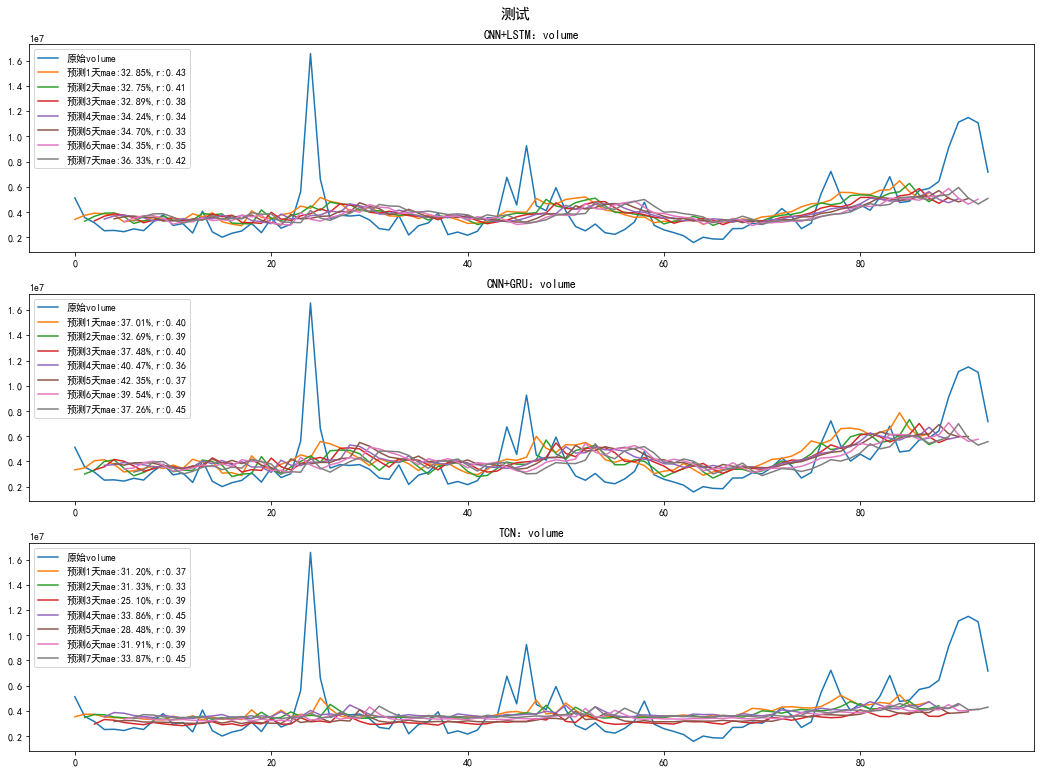

In [83]:
plot_figure(X_test_cnn, X_test, Y_test, title_name='测试')

D:\GWTWORK\Tensorflow_time28\LSTM_MODEL/1642662263/best_model.ckpt LSTM
Model: "afy"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_154 (TimeDi (None, 1, 256, 18)        2048      
_________________________________________________________________
time_distributed_155 (TimeDi (None, 1, 256, 18)        0         
_________________________________________________________________
time_distributed_156 (TimeDi (None, 1, 128, 18)        32896     
_________________________________________________________________
time_distributed_157 (TimeDi (None, 1, 128, 18)        0         
_________________________________________________________________
time_distributed_158 (TimeDi (None, 1, 64, 18)         8256      
_________________________________________________________________
time_distributed_159 (TimeDi (None, 1, 64, 18)         0         
_________________________________________________________

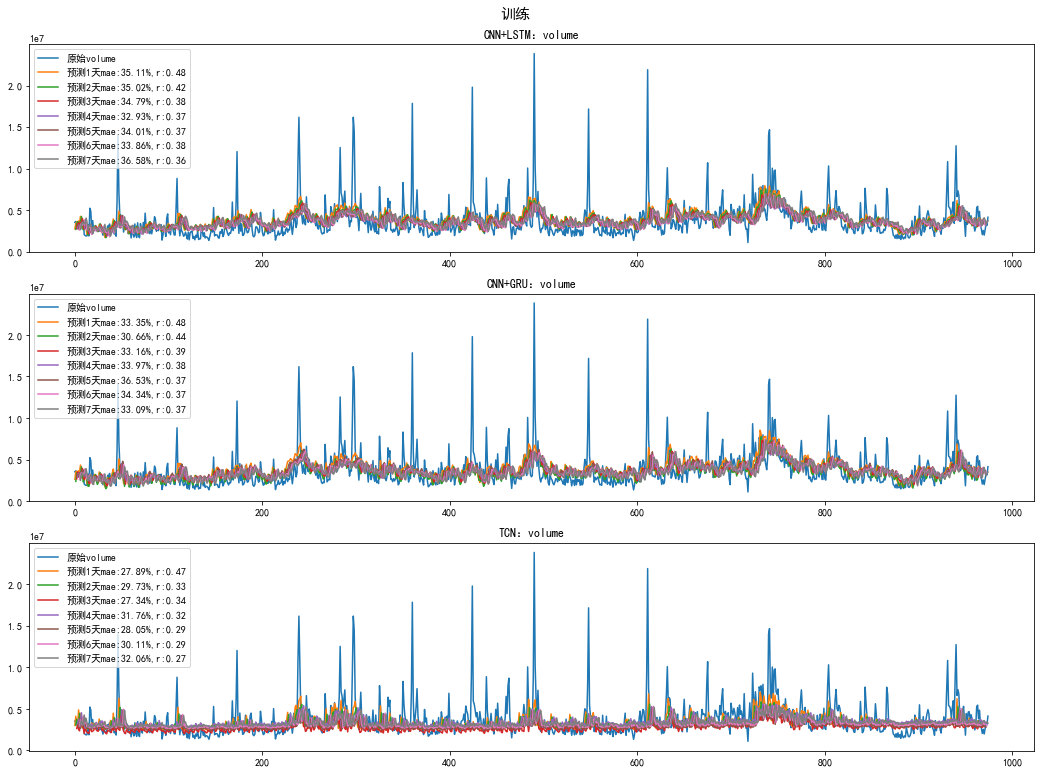

In [84]:
plot_figure(X_train_cnn, X_train, Y_train, title_name='训练')

In [ ]:
plot_figure(X_val_cnn, X_val, Y_val, title_name='验证')

D:\GWTWORK\Tensorflow_time28\LSTM_MODEL/1642662263/best_model.ckpt LSTM
Model: "afy"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_168 (TimeDi (None, 1, 256, 18)        2048      
_________________________________________________________________
time_distributed_169 (TimeDi (None, 1, 256, 18)        0         
_________________________________________________________________
time_distributed_170 (TimeDi (None, 1, 128, 18)        32896     
_________________________________________________________________
time_distributed_171 (TimeDi (None, 1, 128, 18)        0         
_________________________________________________________________
time_distributed_172 (TimeDi (None, 1, 64, 18)         8256      
_________________________________________________________________
time_distributed_173 (TimeDi (None, 1, 64, 18)         0         
_________________________________________________________